In [83]:
import tensorflow as tf
from tensorflow.keras.applications import Xception
from tensorflow.keras import layers
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.callbacks import ModelCheckpoint, ReduceLROnPlateau, EarlyStopping
import matplotlib.pyplot as plt
import numpy as np
import cv2
plt.style.use('dark_background')

In [2]:
gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
    try:
        tf.config.experimental.set_memory_growth(gpus[0], True)
    except RuntimeError as e:
        print(e)

## Dataset

Robbery_Accident_Fire_Database

https://drive.google.com/file/d/11KBgD_W2yOxhJnUMiyBkBzXDPXhVmvCt/view?usp=sharing

Found 3493 images belonging to 3 classes.
Found 872 images belonging to 3 classes.
{'Accident': 0, 'Fire': 1, 'Robbery': 2}


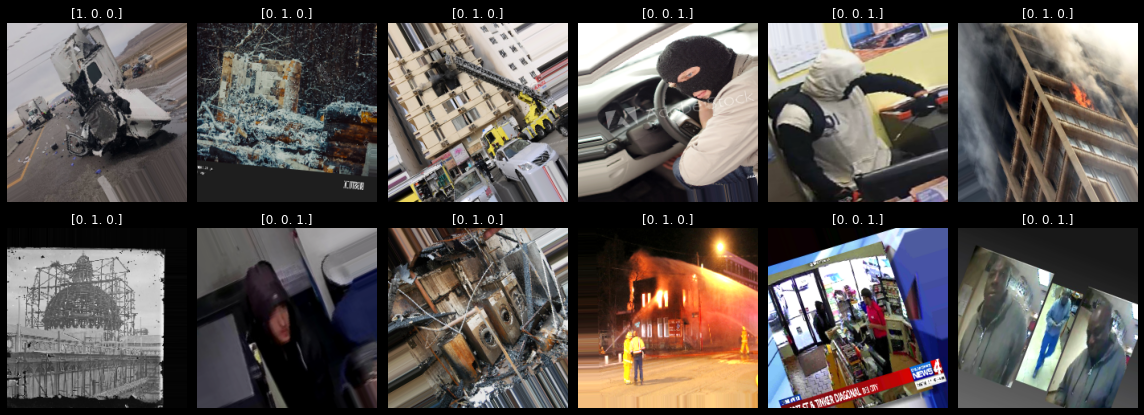

In [84]:
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=30,
    brightness_range=[0.8, 1.2],
    width_shift_range=0.1,
    height_shift_range=0.1,
    horizontal_flip=True,
    zoom_range=0.1,
    validation_split=0.2
)

test_datagen = ImageDataGenerator(
    rescale=1./255,
    validation_split=0.2
)

train_generator = train_datagen.flow_from_directory(
    'C:/Users/Brad/Documents/Dataset/Robbery_Accident_Fire_Database/Robbery_Accident_Fire_Database2',
    target_size=(224, 224),
    color_mode='rgb',
    batch_size=32,
    class_mode='categorical',
    shuffle=True,
    subset='training',
    seed=2022
)

test_generator = test_datagen.flow_from_directory(
    'C:/Users/Brad/Documents/Dataset/Robbery_Accident_Fire_Database/Robbery_Accident_Fire_Database2',
    target_size=(224, 224),
    color_mode='rgb',
    batch_size=32,
    class_mode='categorical',
    shuffle=False,
    subset = 'validation',
    seed=2022
)

print(train_generator.class_indices)

imgs, labels = train_generator.__getitem__(0)

fig, axes = plt.subplots(2, 6, figsize=(16, 6))
for img, label, ax in zip(imgs, labels, axes.flatten()):
    ax.imshow(img)
    ax.set_title(str(label))
    ax.axis('off')
plt.tight_layout()
plt.show()

In [4]:
model = Xception(
    include_top=False,
    weights='imagenet',
    input_shape=(224, 224, 3),
)

for layer in model.layers:
    layer.trainable = True

x = layers.GlobalMaxPooling2D()(model.layers[-1].output)
x = layers.Dropout(0.5)(x)
x = layers.Dense(512, activation='relu')(x)
x = layers.Dense(256, activation='relu')(x)
x = layers.Dense(128, activation='relu')(x)
x = layers.Dense(64, activation='relu')(x)
outputs = layers.Dense(3, activation='softmax')(x)

model = Model(inputs=model.inputs, outputs=outputs)

model.compile(
    optimizer='adam',
    loss='categorical_crossentropy',
    metrics=['acc']
)

model.summary()   

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
block1_conv1 (Conv2D)           (None, 111, 111, 32) 864         input_1[0][0]                    
__________________________________________________________________________________________________
block1_conv1_bn (BatchNormaliza (None, 111, 111, 32) 128         block1_conv1[0][0]               
__________________________________________________________________________________________________
block1_conv1_act (Activation)   (None, 111, 111, 32) 0           block1_conv1_bn[0][0]            
______________________________________________________________________________________________

In [5]:
history = model.fit(
    train_generator,
    epochs=100,
    validation_data=test_generator,
    callbacks=[
        EarlyStopping(monitor='val_acc', patience=10),
        ReduceLROnPlateau(monitor='val_acc', factor=0.2, patience=5, min_lr=1e-6),
        ModelCheckpoint(filepath='model.h5', monitor='val_acc', save_best_only=True),
    ]
)

Epoch 1/100
110/110 [==============================] - ETA: 0s - loss: 0.8911 - acc: 0.5837

C:\Users\Brad\anaconda3\lib\site-packages\PIL\Image.py:962: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


110/110 [==============================] - 86s 734ms/step - loss: 0.8896 - acc: 0.5848 - val_loss: 2.6257 - val_acc: 0.6468
Epoch 2/100
110/110 [==============================] - 80s 722ms/step - loss: 0.4625 - acc: 0.8448 - val_loss: 0.6451 - val_acc: 0.8142
Epoch 3/100
110/110 [==============================] - 80s 723ms/step - loss: 0.3559 - acc: 0.8828 - val_loss: 0.4875 - val_acc: 0.8314
Epoch 4/100
110/110 [==============================] - 80s 722ms/step - loss: 0.3019 - acc: 0.9019 - val_loss: 0.7112 - val_acc: 0.7810
Epoch 5/100
110/110 [==============================] - 80s 727ms/step - loss: 0.2923 - acc: 0.9067 - val_loss: 3.9953 - val_acc: 0.3968
Epoch 6/100
110/110 [==============================] - 80s 725ms/step - loss: 0.2990 - acc: 0.8989 - val_loss: 0.3236 - val_acc: 0.8830
Epoch 7/100
110/110 [==============================] - 80s 722ms/step - loss: 0.2698 - acc: 0.9132 - val_loss: 0.3865 - val_acc: 0.8532
Epoch 8/100
110/110 [==============================] - 80s 7

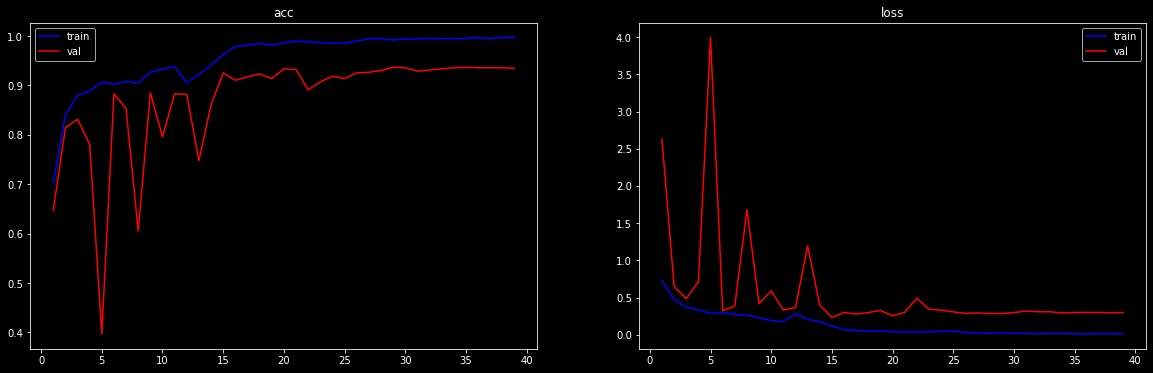

In [85]:
fig, axes = plt.subplots(1, 2, figsize=(20, 6))

xx = range(1, len(history.history['lr']) + 1)

axes[0].plot(xx, history.history['acc'], 'b', label='train')
axes[0].plot(xx, history.history['val_acc'], 'r', label='val')
axes[0].set_title('acc')
axes[0].legend()

axes[1].plot(xx, history.history['loss'], 'b', label='train')
axes[1].plot(xx, history.history['val_loss'], 'r', label='val')
axes[1].set_title('loss')
axes[1].legend()

plt.show()

# GradCAM

In [9]:
last_conv_layer_name = 'block14_sepconv2_act'

grad_model = Model(
    [model.inputs], [model.get_layer(last_conv_layer_name).output, model.layers[-1].output]
)
grad_model.summary()

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
block1_conv1 (Conv2D)           (None, 111, 111, 32) 864         input_1[0][0]                    
__________________________________________________________________________________________________
block1_conv1_bn (BatchNormaliza (None, 111, 111, 32) 128         block1_conv1[0][0]               
__________________________________________________________________________________________________
block1_conv1_act (Activation)   (None, 111, 111, 32) 0           block1_conv1_bn[0][0]            
____________________________________________________________________________________________

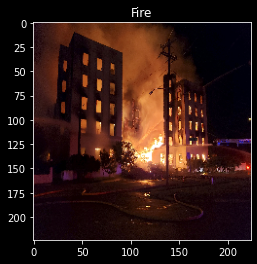

In [86]:
idx = 31

imgs, labels = test_generator.__getitem__(10)
img = imgs[idx:idx+1]
label = list(train_generator.class_indices.keys())[np.argmax(labels[idx])]

plt.title(label)
plt.imshow(img.squeeze())
plt.show()

Reference https://keras.io/examples/vision/grad_cam/

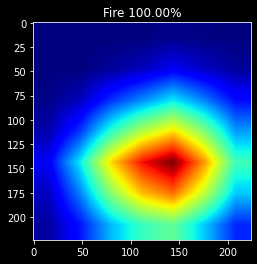

In [87]:
def get_heatmap(img):
    # Then, we compute the gradient of the top predicted class for our input image
    # with respect to the activations of the last conv layer
    with tf.GradientTape() as tape:
        last_conv_layer_output, preds = grad_model(img)
        pred_index = tf.argmax(preds[0])
        class_channel = preds[:, pred_index]

    # This is the gradient of the output neuron (top predicted or chosen)
    # with regard to the output feature map of the last conv layer
    grads = tape.gradient(class_channel, last_conv_layer_output)

    # This is a vector where each entry is the mean intensity of the gradient
    # over a specific feature map channel
    pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2))

    # We multiply each channel in the feature map array
    # by "how important this channel is" with regard to the top predicted class
    # then sum all the channels to obtain the heatmap class activation
    last_conv_layer_output = last_conv_layer_output[0]
    heatmap = last_conv_layer_output @ pooled_grads[..., tf.newaxis]
    heatmap = tf.squeeze(heatmap)

    # For visualization purpose, we will also normalize the heatmap between 0 & 1
    heatmap = tf.maximum(heatmap, 0) / tf.math.reduce_max(heatmap)
    heatmap = heatmap.numpy()
    heatmap_resized = cv2.resize(heatmap, dsize=(224, 224))
    
    return heatmap_resized, preds.numpy().squeeze()

heatmap, pred = get_heatmap(img)

idx = np.argmax(pred)
pred_conf = pred[idx]
pred_label = list(train_generator.class_indices.keys())[idx]

plt.imshow(heatmap, cmap='jet')
plt.title('%s %.2f%%' % (pred_label, pred_conf * 100))
plt.show()

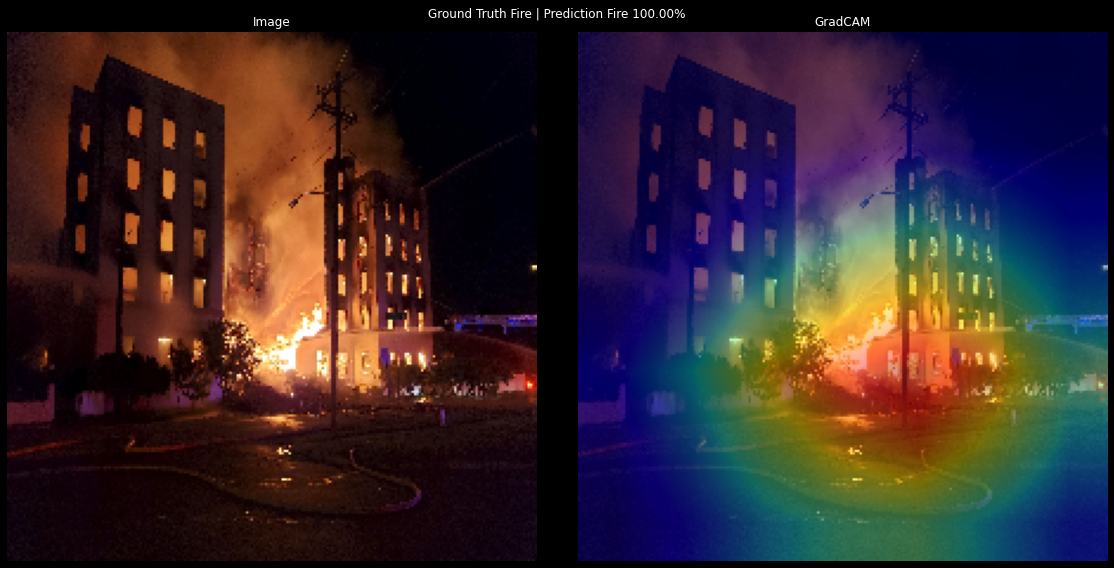

In [88]:
fig, ax = plt.subplots(1, 2, figsize=(16, 8))

fig.suptitle('Ground Truth %s | Prediction %s %.2f%%' % (label, pred_label, pred_conf * 100))

ax[0].imshow(img.squeeze())
ax[0].set_title('Image')
ax[0].axis('off')

ax[1].imshow(img.squeeze(), alpha=1.0)
ax[1].imshow(heatmap, cmap='jet', alpha=0.4)
ax[1].set_title('GradCAM')
ax[1].axis('off')
plt.tight_layout()
plt.show()

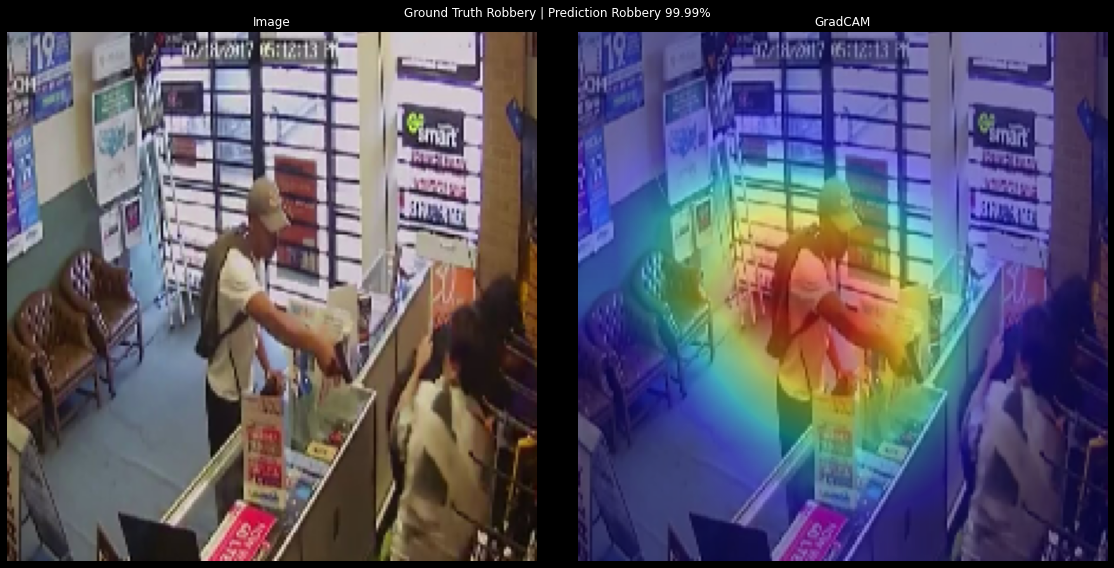

In [89]:
idx = 12

imgs, labels = test_generator.__getitem__(15)
img = imgs[idx:idx+1]
label = list(train_generator.class_indices.keys())[np.argmax(labels[idx])]

heatmap, pred = get_heatmap(img)

idx = np.argmax(pred)
pred_conf = pred[idx]
pred_label = list(train_generator.class_indices.keys())[idx]

fig, ax = plt.subplots(1, 2, figsize=(16, 8))

fig.suptitle('Ground Truth %s | Prediction %s %.2f%%' % (label, pred_label, pred_conf * 100))

ax[0].imshow(img.squeeze())
ax[0].set_title('Image')
ax[0].axis('off')

ax[1].imshow(img.squeeze(), alpha=1.0)
ax[1].imshow(heatmap, cmap='jet', alpha=0.4)
ax[1].set_title('GradCAM')
ax[1].axis('off')
plt.tight_layout()
plt.show()